In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import seaborn as sns 
import gpytorch 

import ipywidgets
from ipywidgets import interact
import IPython
# If in your browser the figures are not nicely vizualized, change the following line.
rcParams['font.size'] = 20
rcParams['figure.figsize'] = (20, 8)

import warnings
warnings.filterwarnings('ignore')

layout = ipywidgets.Layout(width='auto', height='40px')
%load_ext autoreload
%autoreload 2

from sampling.data import heteroskedastic_regression, homoskedastic_regression
from sampling.training import (
    GPLearner,
    SGDLearner,
    BootstrapEnsembleLearner,
    EnsembleLearner,
    DropoutLearner,
    SGLDLearner,
    BayesBackPropLearner,
    SWAGLearner,
    MALALearner
)
train_device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
def plot_predictions(true_x, true_y, train_set, test_set, learner, num_samples=1, title=""):
    idx = true_x.sort()[1]
    eval_x = torch.linspace(-3, 3, 100).unsqueeze(-1)
    plt.plot(true_x[idx], true_y[idx], 'b-', label="Sampled Function")
    plt.plot(train_set.tensors[1], train_set.tensors[2], 'b*', markersize=15, label="Train data")
#     plt.plot(test_set.tensors[1], test_set.tensors[2], 'k*', markersize=15, label="Test data")
    with torch.no_grad():
        mean, lower, upper, epistemic_lower, epistemic_upper = learner.predict(
                eval_x, num_samples=num_samples
        )
    plt.plot(eval_x.squeeze(), mean.numpy(), "g-", label="Mean Prediction")

    if lower is None and epistemic_lower is None:
        pass
    elif epistemic_lower is None:
        plt.fill_between(
                eval_x.squeeze().numpy(), lower.squeeze().numpy(), upper.squeeze().numpy(),
                color="g", alpha=0.3, label="Total Uncertainty"
        )
    else:

        plt.fill_between(
                eval_x.squeeze().numpy(),
                epistemic_lower.squeeze().numpy(),
                epistemic_upper.squeeze().numpy(),
                color="g", alpha=0.3, label="Epistemic Uncertainty"
        )

        plt.fill_between(
                eval_x.squeeze().numpy(),
                epistemic_upper.squeeze().numpy(),
                upper.squeeze().numpy(),
                color="b", alpha=0.3, label="Aleatoric Uncertainty"
        )
        plt.fill_between(
                eval_x.squeeze().numpy(),
                lower.squeeze().numpy(),
                epistemic_lower.squeeze().numpy(),
                color="b", alpha=0.3
        )
    plt.ylim([-1.5, 1])
    plt.legend(loc="upper center", frameon=False, ncol=3)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.title(title)
    plt.show()

def train(learner, num_epochs, train_set, test_set, num_samples=1, title=""):
    losses = learner.train(num_epochs=num_epochs)
    plot_predictions(
            true_x, true_y, train_set, test_set, learner, num_samples=num_samples, title=title
    )
    return losses

## See data-set

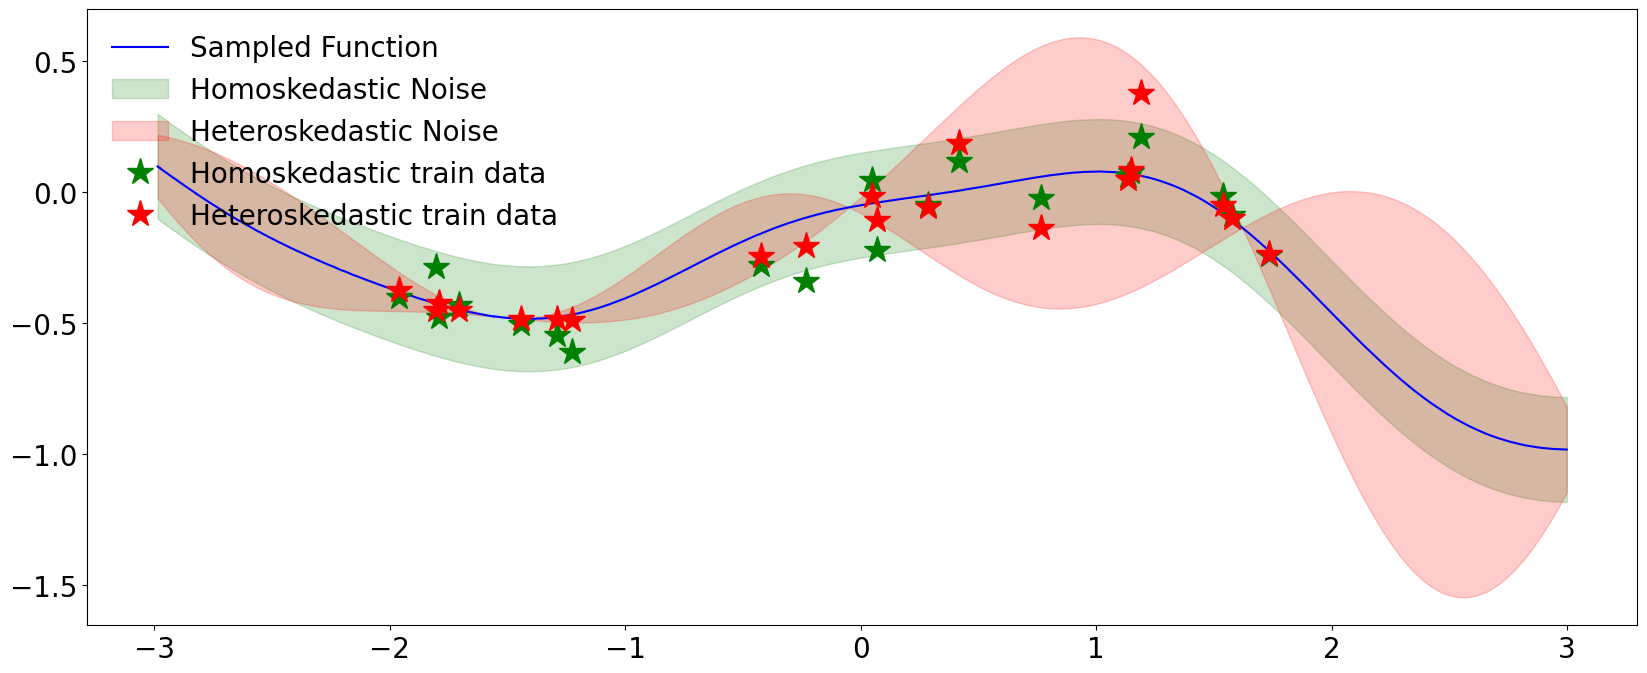

In [3]:
seed = 42
(homo_train_set, homo_test_set), true_x, true_y, kernel = homoskedastic_regression(
        num_points=20, seed=seed
)
(hetero_train_set, hetero_test_set), true_x, true_y, kernel = heteroskedastic_regression(
        num_points=20, seed=seed
)

idx = true_x.sort()[1]
plt.plot(true_x[idx], true_y[idx], 'b-', label="Sampled Function")

# ys = gpytorch.distributions.MultivariateNormal(torch.zeros_like(true_x), kernel(true_x[idx])).sample(
#     sample_shape=torch.Size((100,))
# )
# cov = ys.std(0)

homo_noise = 0.1
plt.fill_between(true_x[idx], true_y[idx] - 2 * homo_noise, true_y[idx] + 2 * homo_noise, color='g', alpha=0.2, label="Homoskedastic Noise")
hetero_noise = 0.1 * torch.abs(torch.sin(2 * true_x[idx]) + 0.1) * ( 0.5 + (1 + true_x[idx]))
plt.fill_between(true_x[idx], true_y[idx] - 2 * hetero_noise, true_y[idx] + 2 * hetero_noise, color='r', alpha=0.2, label="Heteroskedastic Noise")

plt.plot(homo_train_set.tensors[1], homo_train_set.tensors[2], "g*", markersize=20, label="Homoskedastic train data")
plt.plot(hetero_train_set.tensors[1], hetero_train_set.tensors[2], "r*", markersize=20, label="Heteroskedastic train data")

plt.legend(loc="upper left", frameon=False);


In [4]:
def learn_gp(num_epochs, lr, num_points, heteroskedastic):
    IPython.display.clear_output(wait=True)
    plt.close()
    if heteroskedastic:
        train_set, test_set = hetero_train_set, hetero_test_set
    else:
        train_set, test_set = homo_train_set, homo_test_set
    
    train_set.num_points = num_points
    learner = GPLearner(train_set, lr=lr)
    losses = train(learner, num_epochs, train_set, test_set, num_samples=1, title="GP-Regression")

interact(learn_gp, 
        num_epochs=ipywidgets.IntSlider(value=0, min=0, max=200, continuous_update=False),
        lr=ipywidgets.FloatLogSlider(value=0.2, min=-3, max=0, step=0.01, continuous_update=False),
        num_points=ipywidgets.IntSlider(value=15, min=5, max=200, continuous_update=False),
        heteroskedastic=ipywidgets.Dropdown(value=True, options=[True, False], style={'description_width': 'initial'}),
);

interactive(children=(IntSlider(value=0, continuous_update=False, description='num_epochs', max=200), FloatLog…

In [5]:
def learn_sgd(num_epochs, lr, num_points, probabilistic, heteroskedastic):
    IPython.display.clear_output(wait=True)
    plt.close()
    if heteroskedastic:
        train_set, test_set = hetero_train_set, hetero_test_set
    else:
        train_set, test_set = homo_train_set, homo_test_set
    train_set.num_points = num_points
    learner = SGDLearner(
            train_set, batch_size=len(train_set), deterministic=not probabilistic,
            lr=lr, weight_decay=1e-3,
            train_device=train_device,
    )    
    losses = train(learner, num_epochs, train_set, test_set, num_samples=1, title="SGD")
    learner.save_model("models/regression_sgd")

interact(learn_sgd, 
        num_epochs=ipywidgets.IntSlider(value=500, min=200, max=1000, continuous_update=False),
        lr=ipywidgets.FloatLogSlider(value=0.001, min=-4, max=-1, step=0.01, continuous_update=False),
        num_points=ipywidgets.IntSlider(value=15, min=5, max=200, continuous_update=False),
        probabilistic=ipywidgets.Dropdown(value=True, options=[True, False], style={'description_width': 'initial'}),
        heteroskedastic=ipywidgets.Dropdown(value=True, options=[True, False], style={'description_width': 'initial'}),
);

interactive(children=(IntSlider(value=500, continuous_update=False, description='num_epochs', max=1000, min=20…

In [6]:
def learn_ensemble(num_epochs, lr, num_points, probabilistic, heteroskedastic):
    IPython.display.clear_output(wait=True)
    plt.close()
    if heteroskedastic:
        train_set, test_set = hetero_train_set, hetero_test_set
    else:
        train_set, test_set = homo_train_set, homo_test_set
    train_set.num_points = num_points
    learner = EnsembleLearner(
            train_set, batch_size=len(train_set), deterministic=not probabilistic,
            num_heads=5, lr=lr, weight_decay=1e-3, train_device=train_device,
    )
    losses = train(learner, num_epochs, train_set, test_set, num_samples=1, title="Ensemble (no bootstrap)")
    learner.save_model("models/regression_ensemble")


interact(learn_ensemble, 
        num_epochs=ipywidgets.IntSlider(value=500, min=200, max=1000, continuous_update=False),
        lr=ipywidgets.FloatLogSlider(value=0.001, min=-4, max=-1, step=0.01, continuous_update=False),
        num_points=ipywidgets.IntSlider(value=15, min=5, max=200, continuous_update=False),
        probabilistic=ipywidgets.Dropdown(value=True, options=[True, False], style={'description_width': 'initial'}),
        heteroskedastic=ipywidgets.Dropdown(value=True, options=[True, False], style={'description_width': 'initial'}),
);

interactive(children=(IntSlider(value=500, continuous_update=False, description='num_epochs', max=1000, min=20…

In [7]:
def learn_bootstrap_ensemble(num_epochs, lr, num_points, probabilistic, heteroskedastic):
    IPython.display.clear_output(wait=True)
    plt.close()
    if heteroskedastic:
        train_set, test_set = hetero_train_set, hetero_test_set
    else:
        train_set, test_set = homo_train_set, homo_test_set
    train_set.num_points = num_points
    learner = BootstrapEnsembleLearner(
            train_set, batch_size=len(train_set), deterministic=not probabilistic,
            num_heads=5, lr=lr, weight_decay=1e-3, train_device=train_device,
    )
    losses = train(learner, num_epochs, train_set, test_set, num_samples=1, title="Ensemble (with bootstrap)")
    learner.save_model("models/regression_bootstrap")

interact(learn_bootstrap_ensemble, 
        num_epochs=ipywidgets.IntSlider(value=500, min=200, max=1000, continuous_update=False),
        lr=ipywidgets.FloatLogSlider(value=0.001, min=-4, max=-1, step=0.01, continuous_update=False),
        num_points=ipywidgets.IntSlider(value=15, min=5, max=200, continuous_update=False),
        probabilistic=ipywidgets.Dropdown(value=True, options=[True, False], style={'description_width': 'initial'}),
        heteroskedastic=ipywidgets.Dropdown(value=True, options=[True, False], style={'description_width': 'initial'}),
);

interactive(children=(IntSlider(value=500, continuous_update=False, description='num_epochs', max=1000, min=20…

In [8]:
def learn_dropout(dropout_p, num_samples, num_epochs, lr, num_points, probabilistic, heteroskedastic):
    IPython.display.clear_output(wait=True)
    plt.close()
    if heteroskedastic:
        train_set, test_set = hetero_train_set, hetero_test_set
    else:
        train_set, test_set = homo_train_set, homo_test_set
    train_set.num_points = num_points
    learner = DropoutLearner(
            train_set=train_set, batch_size=len(train_set), deterministic=not probabilistic,
            lr=lr, weight_decay=1e-3,
            dropout_p=dropout_p,
            train_device=train_device
    )
    losses = train(
        learner, num_epochs, train_set, test_set, num_samples=num_samples, title="MC-Dropout")
    learner.save_model("models/regression_dropout")


interact(learn_dropout, 
        dropout_p=ipywidgets.FloatLogSlider(value=0.05, min=-3, max=0, step=0.1, continuous_update=False),
        num_samples=ipywidgets.IntSlider(value=1000, min=10, max=5000, continuous_update=False),
        num_epochs=ipywidgets.IntSlider(value=500, min=200, max=1000, continuous_update=False),
        lr=ipywidgets.FloatLogSlider(value=0.001, min=-4, max=-1, step=0.01, continuous_update=False),
        num_points=ipywidgets.IntSlider(value=15, min=5, max=200, continuous_update=False),
        probabilistic=ipywidgets.Dropdown(value=True, options=[True, False], style={'description_width': 'initial'}),
        heteroskedastic=ipywidgets.Dropdown(value=True, options=[True, False], style={'description_width': 'initial'}),
);    

interactive(children=(FloatLogSlider(value=0.05, continuous_update=False, description='dropout_p', max=0.0, mi…

In [9]:
from torch.distributions import Normal, Laplace
def learn_bayes_by_backprop(prior, num_samples, num_epochs, lr, num_points, probabilistic, heteroskedastic):
    IPython.display.clear_output(wait=True)
    plt.close()
    if heteroskedastic:
        train_set, test_set = hetero_train_set, hetero_test_set
    else:
        train_set, test_set = homo_train_set, homo_test_set
    train_set.num_points = num_points
    learner = BayesBackPropLearner(
            train_set=train_set,
            batch_size=len(train_set), deterministic=not probabilistic,
            lr=lr,
            prior=prior,
            train_device=train_device,
    )
    
    losses = train(
        learner, num_epochs, train_set, test_set, num_samples=num_samples, title="Bayes by BackProp")

    learner.save_model("models/regression_bbbp")
    
interact(learn_bayes_by_backprop, 
        prior=ipywidgets.Dropdown(options=[Laplace(0, 0.1), Laplace(0, 1.0), Laplace(0, 10.0), Normal(0, 0.1), Normal(0, 1.0), Normal(0, 10.0)]),
        num_samples=ipywidgets.IntSlider(value=32, min=5, max=50, continuous_update=False),
        num_epochs=ipywidgets.IntSlider(value=500, min=200, max=1000, continuous_update=False),
        lr=ipywidgets.FloatLogSlider(value=0.01, min=-4, max=-1, step=0.01, continuous_update=False),
        num_points=ipywidgets.IntSlider(value=15, min=5, max=200, continuous_update=False),
        probabilistic=ipywidgets.Dropdown(value=True, options=[True, False], style={'description_width': 'initial'}),
        heteroskedastic=ipywidgets.Dropdown(value=True, options=[True, False], style={'description_width': 'initial'}),
);    

interactive(children=(Dropdown(description='prior', options=(Laplace(loc: 0.0, scale: 0.10000000149011612), La…

In [10]:
def learn_swag(num_samples, num_epochs, lr, num_points, probabilistic, heteroskedastic):
    IPython.display.clear_output(wait=True)
    plt.close()
    if heteroskedastic:
        train_set, test_set = hetero_train_set, hetero_test_set
    else:
        train_set, test_set = homo_train_set, homo_test_set
    train_set.num_points = num_points 
    learner = SWAGLearner(
            train_set=train_set,
            batch_size=len(train_set), deterministic=not probabilistic,
            lr=lr, weight_decay=1e-3, burn_in=5, sub_sample=1,
            train_device=train_device
    )
    
    losses = train(
        learner, num_epochs, train_set, test_set, num_samples=num_samples, title="SWAG")

    learner.save_model("models/regression_swag")

interact(learn_swag, 
        num_samples=ipywidgets.IntSlider(value=10, min=5, max=50, continuous_update=False),
        num_epochs=ipywidgets.IntSlider(value=500, min=200, max=1000, continuous_update=False),
        lr=ipywidgets.FloatLogSlider(value=0.005, min=-4, max=-1, step=0.01, continuous_update=False),
        num_points=ipywidgets.IntSlider(value=15, min=5, max=200, continuous_update=False),
        probabilistic=ipywidgets.Dropdown(value=True, options=[True, False], style={'description_width': 'initial'}),
        heteroskedastic=ipywidgets.Dropdown(value=True, options=[True, False], style={'description_width': 'initial'}),
); 

interactive(children=(IntSlider(value=10, continuous_update=False, description='num_samples', max=50, min=5), …

In [11]:
def learn_sgld(num_samples, num_epochs, lr, num_points, probabilistic, heteroskedastic):
    IPython.display.clear_output(wait=True)
    plt.close()
    if heteroskedastic:
        train_set, test_set = hetero_train_set, hetero_test_set
    else:
        train_set, test_set = homo_train_set, homo_test_set
    
    train_set.num_points = num_points
    learner = SGLDLearner(
            train_set=train_set,
            batch_size=len(train_set), deterministic=not probabilistic,
            lr=0.02, weight_decay=1e-3, num_iter=num_epochs,
            burn_in=5, sub_sample=30, max_size=num_samples,
            train_device=train_device
    )
    losses = train(
        learner, num_epochs, train_set, test_set, num_samples=1, title="SGLD")
    learner.save_model("models/regression_sgld")


interact(learn_sgld, 
        num_samples=ipywidgets.IntSlider(value=50, min=5, max=200, continuous_update=False),
        num_epochs=ipywidgets.IntSlider(value=10000, min=1000, max=10000, continuous_update=False),
        lr=ipywidgets.FloatLogSlider(value=0.02, min=-4, max=-1, step=0.01, continuous_update=False),
        num_points=ipywidgets.IntSlider(value=15, min=5, max=200, continuous_update=False),
        probabilistic=ipywidgets.Dropdown(value=True, options=[True, False], style={'description_width': 'initial'}),
        heteroskedastic=ipywidgets.Dropdown(value=True, options=[True, False], style={'description_width': 'initial'}),
);   

interactive(children=(IntSlider(value=50, continuous_update=False, description='num_samples', max=200, min=5),…

In [12]:
def learn_mala(num_samples, num_epochs, lr, num_points, probabilistic, heteroskedastic):
    IPython.display.clear_output(wait=True)
    plt.close()
    if heteroskedastic:
        train_set, test_set = hetero_train_set, hetero_test_set
    else:
        train_set, test_set = homo_train_set, homo_test_set
    
    train_set.num_points = num_points
    learner = MALALearner(
            train_set=train_set,
            batch_size=len(train_set), deterministic=not probabilistic,
            lr=0.02, weight_decay=1e-3, num_iter=num_epochs,
            burn_in=5, sub_sample=30, max_size=num_samples,
            train_device=train_device
    )
    losses = train(
        learner, num_epochs, train_set, test_set, num_samples=1, title="MALA")
    learner.save_model("models/regression_mala")


interact(learn_mala, 
        num_samples=ipywidgets.IntSlider(value=50, min=5, max=200, continuous_update=False),
        num_epochs=ipywidgets.IntSlider(value=10000, min=1000, max=10000, continuous_update=False),
        lr=ipywidgets.FloatLogSlider(value=0.02, min=-4, max=-1, step=0.01, continuous_update=False),
        num_points=ipywidgets.IntSlider(value=15, min=5, max=200, continuous_update=False),
        probabilistic=ipywidgets.Dropdown(value=True, options=[True, False], style={'description_width': 'initial'}),
        heteroskedastic=ipywidgets.Dropdown(value=True, options=[True, False], style={'description_width': 'initial'}),
); 

interactive(children=(IntSlider(value=50, continuous_update=False, description='num_samples', max=200, min=5),…